In [76]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
# sns.set(style='ticks', context='paper', font='CMU Sans Serif')
sns.set(style='ticks', context='paper')
import numpy as np
from util import plot_cdf, color_list,hatch_list
from collections import defaultdict 

In [2]:
_fontsize=15

In [98]:
# path performance
NR_PATHS_SAMPLED=500
N=10000
N_FLOW_THRESHOLD_LIST=[20,20,20]
# mlsys_dir_list=["mlsys_bt100"]
mlsys_dir_list=["ns3-path-all"]
legend_list=['ns-3',"ns-3-path",'Parsimon']
mix_file = '../spec/motivation.mix.json'
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./main_{mlsys_dir}_{NR_PATHS_SAMPLED}_{N}_{N_FLOW_THRESHOLD_LIST[0]}_test.npz'
    # legend_list.append(mlsys_dir)
    
    if not os.path.exists(save_file):
        p99_sldn_path=defaultdict(list)
        n_flows_per_path_dict=defaultdict(list)
        n_freq_per_path_dict=defaultdict(list)
        n_link_per_path_dict=defaultdict(list)
        p99_sldn=defaultdict(list)
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes=[mixes[1]]
        for mix_idx,mix in enumerate(mixes):
            mix_id = mix['id']
            mix_dir = f'../data/{mix_id}'
            # Accuracy metrics
            df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
            df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
            
            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            p99_sldn_ns3_network=np.percentile(sldn_ns3,99)
            p99_sldn_pmn_network=np.percentile(sldn_pmn_m,99)
            
            id_to_sldn_ns3=dict(zip(df_ns3['flow_id'],df_ns3['slowdown']))
            id_to_sldn_pmn_m=dict(zip(df_pmn_m['flow_id'],df_pmn_m['slowdown']))
            
            sldn_ns3_path_list=[]
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv'):
                # print(f"mix_id: {mix_id}, path_idx: {path_idx}")
                df_ns3_path = pd.read_csv(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv')
                flowid_list_ns3_path=df_ns3_path['flow_id']
                sldn_ns3_path=df_ns3_path['slowdown']
                
                sldn_ns3_tmp=[id_to_sldn_ns3[flowid] for flowid in flowid_list_ns3_path]
                sldn_pmn_m_tmp=[id_to_sldn_pmn_m[flowid] for flowid in flowid_list_ns3_path]
                
                p99_sldn_ns3=np.percentile(sldn_ns3_tmp,99)
                p99_sldn_pmn=np.percentile(sldn_pmn_m_tmp,99)
                p99_sldn_ns3_path=np.percentile(sldn_ns3_path,99)
                
                p99_sldn_path[mix_id].append([p99_sldn_ns3,p99_sldn_ns3_path,p99_sldn_pmn])
                
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_per_path_dict[mix_id].append(n_freq)
                    
                    n_flow_in_f=int(data[-3])
                    n_flow_in_f_prime=int(data[-2])
                    assert n_flow_in_f==len(flowid_list_ns3_path)
                    
                    n_flows_per_path_dict[mix_id].append([n_flow_in_f,n_flow_in_f_prime])
                    
                    if n_flow_in_f>=N_FLOW_THRESHOLD_LIST[mix_idx]:
                        for _ in range(n_freq):
                            tmp=np.random.choice(sldn_ns3_path, N, replace=True)
                            sldn_ns3_path_list.extend(tmp)
                    
                    n_link=len(data[0].split("|"))-1
                    n_link_per_path_dict[mix_id].append(n_link)
                    
                path_idx+=1
            assert np.sum(n_freq_per_path_dict[mix_id])==NR_PATHS_SAMPLED
            p99_sldn_ns3_path_network=np.percentile(sldn_ns3_path_list,99)
            p99_sldn[mix_id]=[p99_sldn_ns3_network,p99_sldn_ns3_path_network,p99_sldn_pmn_network,]
        # np.savez(save_file, p99_sldn_path=p99_sldn_path,n_flows_per_path_dict=n_flows_per_path_dict,n_freq_per_path_dict=n_freq_per_path_dict,p99_sldn=p99_sldn,n_link_per_path_dict=n_link_per_path_dict)
    else:
        data=np.load(save_file, allow_pickle=True)
        p99_sldn_path=data['p99_sldn_path'].item()
        n_flows_per_path_dict=data['n_flows_per_path_dict'].item()
        n_freq_per_path_dict=data['n_freq_per_path_dict'].item()
        p99_sldn=data['p99_sldn'].item()
        n_link_per_path_dict=data['n_link_per_path_dict'].item()
        
print(f"p99_sldn: {p99_sldn}")

p99_sldn: defaultdict(<class 'list'>, {156: [12.734230530407611, 11.571374045801528, 13.907967788493877]})


mix_id: 20
mix_id: 179
mix_id: 12
[(2, 499), (2, 497), (2, 453)]
plot_data: (3, 1449), plot_data_n_flows: (2, 1449), plot_data_n_link: (1449,)
(2, 1449)
(2, 1449)


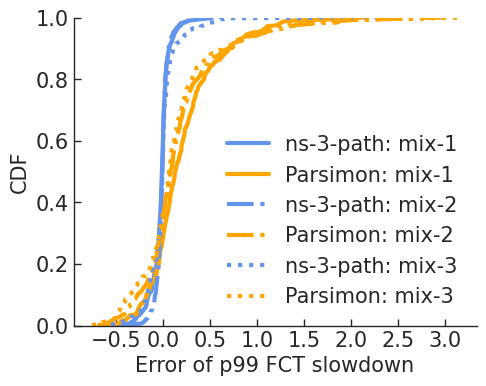

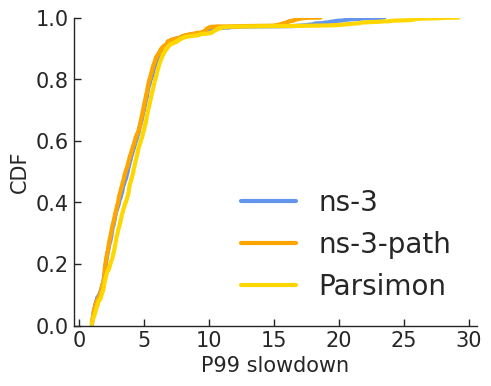

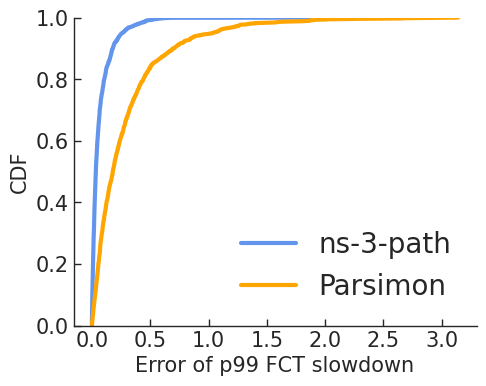

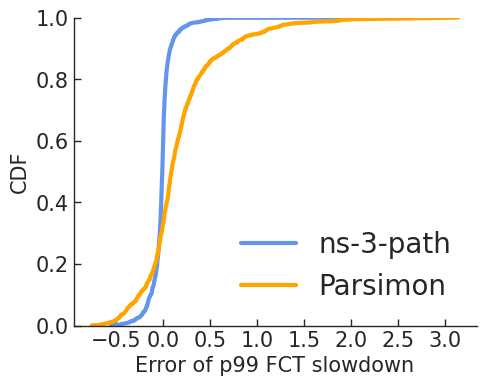

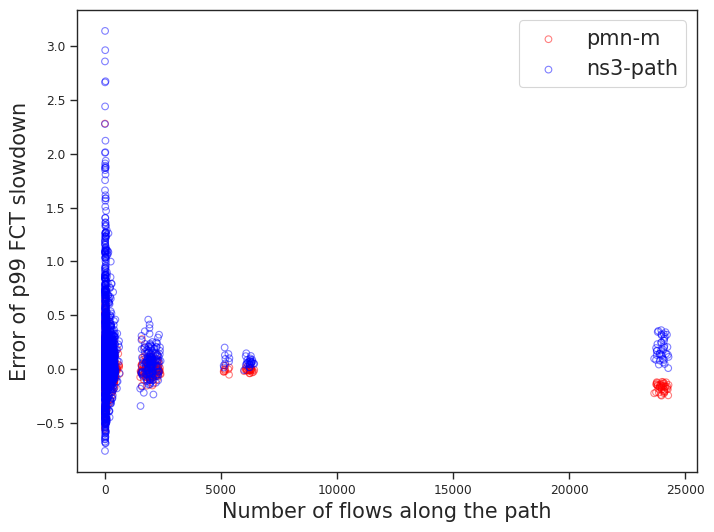

(2, 1449)
(2, 1449)
0.08593192632723569


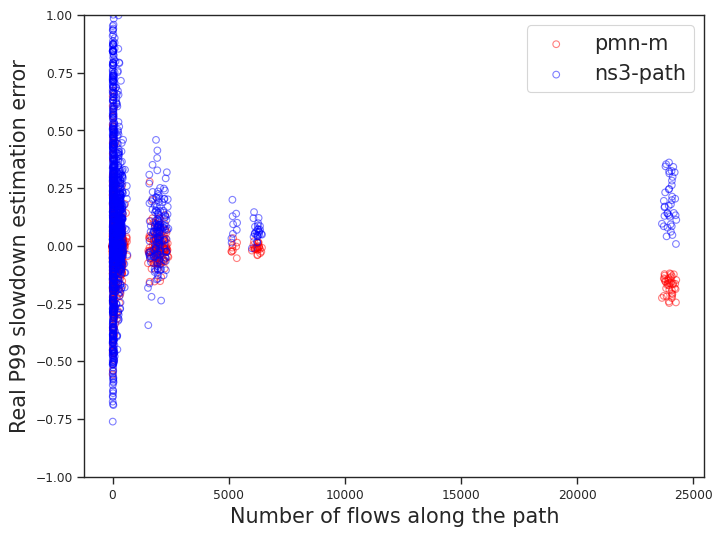

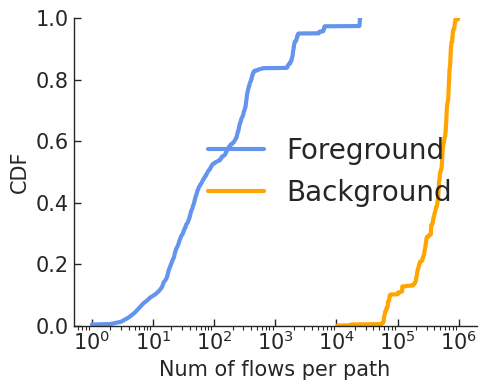

In [87]:
plot_data=[]
plot_data_n_flows=[]
plot_data_n_link=[]
target_mix_list=[20,179,12]
plot_data_mix=[]
plot_data_per_mix=[]
plot_data_n_flow_per_mix=[]
legend_per_mix=[]
for mix_idx,mix_id in enumerate(target_mix_list):
    print(f"mix_id: {mix_id}")
    tmp=p99_sldn_path[mix_id]
    plot_data.extend(tmp)
    
    tmp_n_flows=n_flows_per_path_dict[mix_id]
    plot_data_n_flows.extend(tmp_n_flows)
    
    tmp_n_link=n_link_per_path_dict[mix_id]
    plot_data_n_link.extend(tmp_n_link)

    plot_data_mix.extend([f'mix-{mix_idx+1}']*len(tmp))
    
    tmp=np.array(p99_sldn_path[mix_id]).transpose()
    for i in range(1, tmp.shape[0]):
        tmp[i]=((tmp[i]-tmp[0])/tmp[0])
        plot_data_per_mix.append(np.array(tmp[i]))
        legend_per_mix.append(f'{legend_list[i]}: mix-{mix_idx+1}')

    plot_data_n_flow_per_mix.append(np.array(n_flows_per_path_dict[mix_id]).transpose())

plot_cdf(plot_data_per_mix,'figs/motivation_error_path.pdf',legend_per_mix,'Error of p99 FCT slowdown',legend_font=15,group_size=2,loc=4,rotate_xaxis=False)
  
plot_data=np.array(plot_data).transpose()
plot_data_n_flows=np.array(plot_data_n_flows).transpose()
plot_data_n_link=np.array(plot_data_n_link).transpose()
print([x.shape for x in plot_data_n_flow_per_mix])
print(f"plot_data: {plot_data.shape}, plot_data_n_flows: {plot_data_n_flows.shape}, plot_data_n_link: {plot_data_n_link.shape}")

plot_cdf(plot_data,None,legend_list,'P99 slowdown',legend_font=20,group_size=len(plot_data),loc=4,rotate_xaxis=False)

error_abs=[]
for i in range(1,len(plot_data)):
    error_abs.append(np.abs(plot_data[i]-plot_data[0])/plot_data[0])
plot_cdf(error_abs,None,[legend_list[i] for i in range(1,len(legend_list))],'Error of p99 FCT slowdown',legend_font=20,group_size=len(error_abs),loc=4,rotate_xaxis=False)

error_real=[]
for i in range(1,len(plot_data)):
    error_real.append((plot_data[i]-plot_data[0])/plot_data[0])
plot_cdf(error_real,None,[legend_list[i] for i in range(1,len(legend_list))],'Error of p99 FCT slowdown',legend_font=20,group_size=len(error_real),loc=4,rotate_xaxis=False) 

figure, ax = plt.subplots(figsize=(8, 6))
error_real=np.array(error_real)
print(error_real.shape)
new_data=np.array([error_real[1],plot_data_n_flows[0]])
print(new_data.shape)
plt.scatter(plot_data_n_flows[0],error_real[0],marker='o',edgecolors='red',label='pmn-m',alpha=0.5,facecolors='none')
plt.scatter(plot_data_n_flows[0],error_real[1],marker='o',edgecolors='blue',label='ns3-path',alpha=0.5,facecolors='none')
plt.legend(fontsize=_fontsize)
plt.xlabel('Number of flows along the path', fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown', fontsize=_fontsize)
plt.show()

figure, ax = plt.subplots(figsize=(8, 6))
error_real=np.array(error_real)
print(error_real.shape)
new_data=np.array([error_real[1],plot_data_n_flows[0]])
print(new_data.shape)
print(np.median(error_real[1]))
plt.scatter(plot_data_n_flows[0],error_real[0],marker='o',edgecolors='red',label='pmn-m',alpha=0.5,facecolors='none')
plt.scatter(plot_data_n_flows[0],error_real[1],marker='o',edgecolors='blue',label='ns3-path',alpha=0.5,facecolors='none')
plt.legend(fontsize=_fontsize)
plt.xlabel('Number of flows along the path', fontsize=_fontsize)
plt.ylabel('Real P99 slowdown estimation error', fontsize=_fontsize)
plt.ylim(-1.0,1.0)
plt.show()

plot_cdf(plot_data_n_flows,None,['Foreground','Background'],'Num of flows per path',legend_font=20,group_size=len(plot_data),loc='center right',rotate_xaxis=False,log_switch=True)

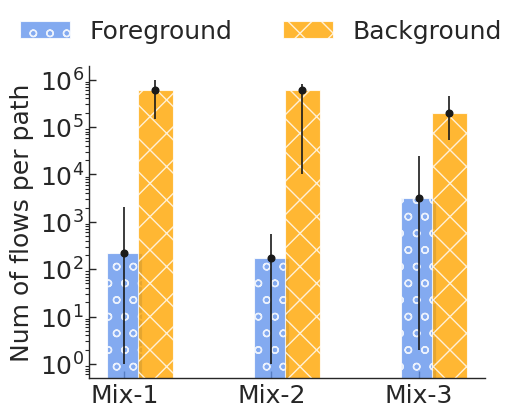

In [88]:
def plot_bar(
    datas,
    data_min,
    data_max,
    xs,
    linelabels=None,
    label=None,
    xticklabel=None,
    y_label="CDF",
    name="ss",
    log_switch=False,
    fontsize=15,
    legend_font=15,
    loc=2,
    ncol=1,
    xlim=None,
    ylim=None,
    ylim_bottom=None,
    xlim_bottom=None,
    text_x=0.04,
    text_y=0.6,
    text_font=12,
    text_rotation=-30,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(5.2, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(label, fontsize=_fontsize)
    legend_target = []
    for i in range(len(datas)):
        tmp_data = datas[i]
        tmp_data_min = data_min[i]
        tmp_data_max = data_max[i]
        X = np.arange(0.1, 1, 1 / len(tmp_data)) + 0.07 * i
        width = 0.24 / len(tmp_data)
        tmp = ax.bar(
            X,
            tmp_data,
            color=color_list[i],
            hatch=hatch_list[i],
            width=width,
            alpha=0.8,
        )
        legend_target.append(tmp)
        ax.errorbar(
            X,
            tmp_data,
            yerr=[tmp_data - tmp_data_min, tmp_data_max - tmp_data],
            fmt="o",
            color="k",
        )
        # for x, y, p in zip(X - text_x, tmp_data + text_y, tmp_data):
        #     plt.text(x, y, int(p), fontsize=text_font, rotation=text_rotation)
    legend_properties = {"size": legend_font}
    # handles = [
    #     plt.Rectangle((0, 0), 1, 1, color=color_list[ii]) for ii in range(len(linelabels))
    # ]

    ax.legend(
        legend_target,
        linelabels,
        loc=loc,
        ncol=ncol,
        prop=legend_properties,
        frameon=False,
        bbox_to_anchor=(1.1, 1.0),
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    if ylim_bottom:
        plt.ylim(bottom=ylim_bottom)
    if ylim:
        plt.ylim(top=ylim)

    if log_switch:
        ax.set_yscale("log")

    plt.tight_layout()

    plt.tight_layout(pad=0.5, w_pad=0.01, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(
        np.arange(0.1, 0.9, 1 / (len(datas[-1]))),
        xticklabel,
        fontsize=_fontsize,
        rotation=0,
    )
    if name:
        plt.savefig(name, bbox_inches="tight", pad_inches=0)
plot_bar(
        np.array([np.mean(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        np.array([np.min(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        np.array([np.max(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        None,
        linelabels=["Foreground", "Background"],
        label="",
        xticklabel=["Mix-1", "Mix-2", "Mix-3"],
        y_label="Num of flows per path",
        name='figs/motivation_n_flows.pdf',
        log_switch=True,
        legend_font=18,
        fontsize=18,
        # ylim_bottom=0,
        # ylim=10000,
        # xlim=1,
        # xlim_bottom=0,
        text_x=0.05,
        text_y=10,
        ncol=2,
        text_font=15,
        text_rotation=0,
        loc=4,
    )


        mix  n_link     error   n_flow       kind
0     mix-1       6  0.003258  100-500  ns-3-path
1     mix-1       6  0.000125  100-500  ns-3-path
2     mix-1       6  0.026215  100-500  ns-3-path
3     mix-1       6  0.141018  100-500  ns-3-path
4     mix-1       6  0.021881  100-500  ns-3-path
...     ...     ...       ...      ...        ...
2893  mix-3       2  0.308387     >500   Parsimon
2894  mix-3       2  0.269735     >500   Parsimon
2895  mix-3       2 -0.029057     >500   Parsimon
2896  mix-3       2 -0.343160     >500   Parsimon
2897  mix-3       2 -0.181735     >500   Parsimon

[2898 rows x 5 columns]


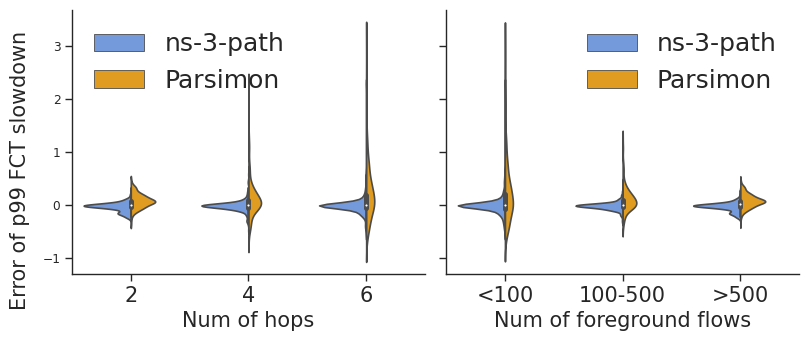

In [96]:
def violins(df):
    xs_labels_orders_rot = [
        # ('mix', 'Various mixes', ['mix-1', 'mix-2', 'mix-3'], 0),
        ('n_link', 'Num of hops', [2, 4, 6], 0),
        ('n_flow', 'Num of foreground flows', ['<100', '100-500', '>500'], 0),
    ]
    legend_loc_list=['upper left','upper right']
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.2, 3.5), sharey=True)

    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]

        filtered_df = df[df[x].isin(order)]
        ax = sns.violinplot(
            data=filtered_df,
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[i],
            split=True,
            palette=color_list,
        )
        ax.set_xlabel(label,fontsize=15)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
            tick.set_fontsize(15)
        ax.set_ylabel('')
    # Remove "kind" from the legend
    for idx,ax in enumerate(axs.flat):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 18})
    sns.despine()
    
    fig.supylabel('Error of p99 FCT slowdown',fontsize=15)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
n_flow_str_list=[] 
for n_flow in plot_data_n_flows[0]:
    if n_flow<100:
        n_flow_str_list.append('<100')
    elif n_flow<500:
        n_flow_str_list.append('100-500')
    else:
        n_flow_str_list.append('>500')
df_ns3_path = pd.DataFrame({
    'mix': plot_data_mix,
    'n_link': plot_data_n_link,
    'error': error_real[0],
    'n_flow': n_flow_str_list,
})

df_pmn = pd.DataFrame({
    'mix': plot_data_mix, # 'Various mixes
    'n_link': plot_data_n_link,
    'error': error_real[1],
    'n_flow': n_flow_str_list,
})

df_ns3_path['kind'] = 'ns-3-path'
df_pmn['kind'] = 'Parsimon' 
df_violin = pd.concat([df_ns3_path,df_pmn], ignore_index=True)
print(df_violin)
violins(df_violin)
plt.savefig('figs/motivation_violin.pdf', bbox_inches='tight')
